In [22]:
# Import data from file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [122]:
# Load data
df_hr = pd.read_csv('HR_data.csv')

# delete unneccessary columns
df_hr = df_hr.drop(['Unnamed: 0'], axis=1)
df_hr.head()

# Replace string in column
df_hr['Phase'] = df_hr['Phase'].str.replace('phase', '').astype(int)
df_hr['Round'] = df_hr['Round'].str.replace('round_', '').astype(int)
df_hr['Cohort'] = df_hr['Cohort'].str.replace('D1_', '').astype(int)
df_hr.nunique()


HR_Mean       165
HR_Median     163
HR_std        165
HR_Min        163
HR_Max        159
HR_AUC        165
Round           4
Phase           3
Individual     14
Puzzler         2
Frustrated      9
Cohort          2
dtype: int64

In [24]:
from sklearn.preprocessing import StandardScaler

# Define features and target
col_names = np.array(df_hr.columns)

X = df_hr[col_names[col_names != 'Frustrated']]
y = df_hr['Frustrated']
groups = X['Individual'].values

# Create a StandardScaler instance
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on the training data
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

In [25]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error


def train(model, logging = True)-> list[float]:

    # Initialize the Leave-One-Group-Out cross-validator
    logo = LeaveOneGroupOut()

    # Initialize the model
    rf = model
    # Lists to store scores for each fold
    test_scores = []

    # Training loop for Leave-One-Group-Out cross-validation
    for train_index, test_index in logo.split(X, y, groups):
        # Split data into train and test sets for this fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        rf.fit(X_train, y_train)
    
        
        # Evaluate on test data
        y_test_pred = rf.predict(X_test)
        test_accuracy = mean_squared_error(y_test, y_test_pred)
        test_scores.append(test_accuracy)

    # Print the cross-validation scores
    # print("Leave-One-Group-Out Cross-Validation")
    # print(f"Mean Training Score: {np.mean(train_scores)}")
    if logging: print(f"Mean Test Score: {np.mean(test_scores)}")
    return test_scores




In [113]:
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


mse_randomforrest = train(RandomForestClassifier(random_state=42))
mse_mlp = train(MLPClassifier(random_state=10, hidden_layer_sizes=(64,16), solver='sgd', alpha=0.001, learning_rate='adaptive'))
mse_dummy = train(DummyClassifier(strategy='most_frequent', random_state=42))

Mean Test Score: 4.934523809523809
Mean Test Score: 5.327380952380952
Mean Test Score: 5.351190476190476


In [114]:
randomforrest_list = []
mlp_list = []
dummy_list = []
logistic_list = []
n=45
for x in range(0, n):
    randomforrest_list.append(train(RandomForestClassifier(random_state=x), logging=False))
    mlp_list.append(train(MLPClassifier(random_state=x+n*1), logging=False))
    dummy_list.append(train(DummyClassifier(strategy='most_frequent', random_state=x+n*2), logging=False))
    if x%5 == 0:
        print(x)
    


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145


In [115]:
# Array flattening
def flat_arr(arr:list)->np.ndarray:
    return np.array(arr).flatten()

randomforrest_arr = flat_arr(randomforrest_list)
mlp_arr = flat_arr(mlp_list)
dummy_arr = flat_arr(dummy_list)
logistic_arr = flat_arr(logistic_list)

In [117]:
# save to pickle
data = {'Randomforrest':randomforrest_list, 'ANN':mlp_list, 'Dummy':dummy_list}
df = pd.DataFrame(data)
df.to_pickle('mse.pkl') 

In [90]:
# Log trans
randomforrest_log = np.log(randomforrest_arr)
mlp_log = np.log(mlp_arr)
dummy_log = np.log(dummy_arr)
logistic_log = np.log(logistic_arr)

Post hoc

In [95]:
from scipy.stats import kruskal

stat, p = kruskal(randomforrest_arr, mlp_arr, dummy_arr, logistic_arr)
print(p)

nan


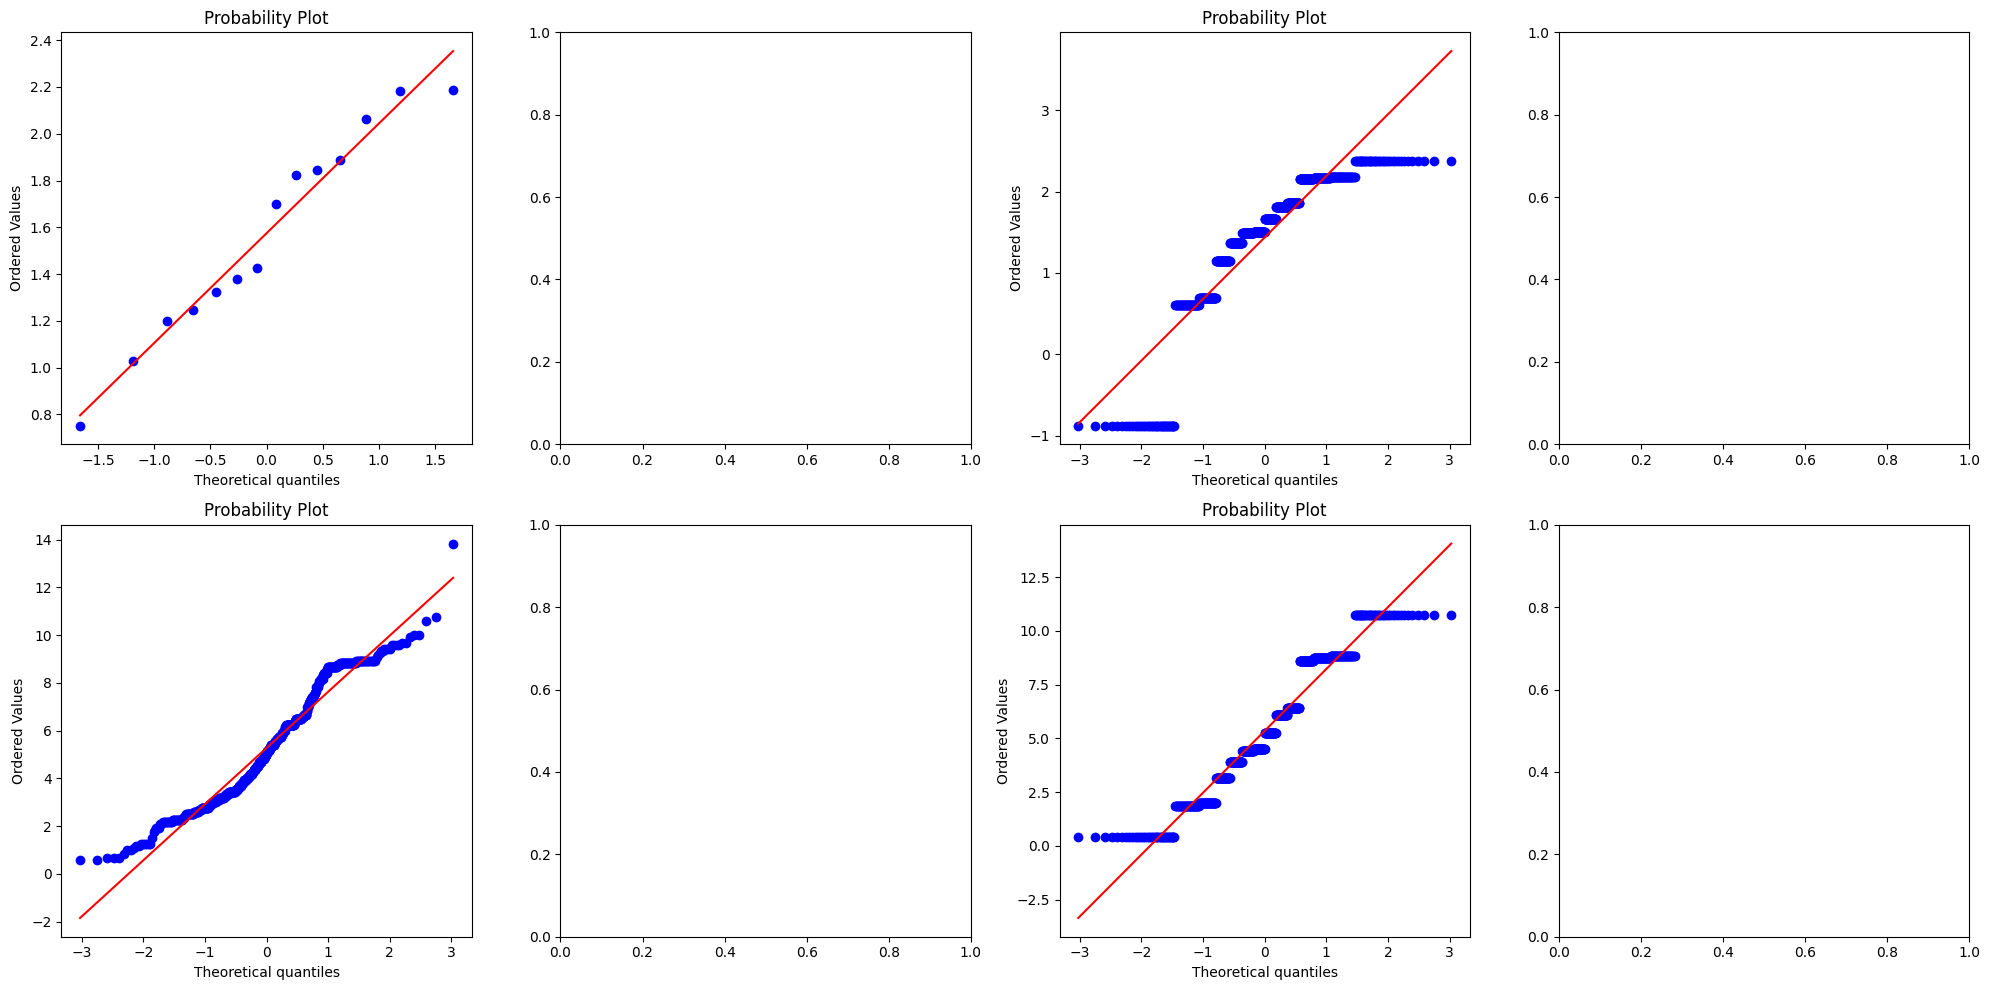

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


sns.histplot(randomforrest_log, color='blue', label='randomforrest', bins=25)

def qq_plot(arr, ax):
    # Create qq plot
    stats.probplot(arr, dist="norm", plot=ax)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns

data = [randomforrest_log, mlp_log, dummy_log, logistic_log, randomforrest_arr, mlp_arr, dummy_arr, logistic_arr]

for i in range(2):
    for j in range(4):
        qq_plot(data[i*4 + j], axs[i, j])

plt.tight_layout()
plt.show()
